# Helper Functions

## Packets

In [2]:
import heapq
import random
import numpy as np
import pandas as pd
import seaborn as sn
import networkx as nx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.utils import from_networkx
from torch_geometric.data import InMemoryDataset
from torch_geometric.nn.models import GNNExplainer
from torch_geometric.nn.conv import SAGEConv, GraphConv

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__)
print(torch_geometric.__version__)
print(device)

1.11.0
2.0.4
cuda


## GNNs

In [3]:
class GNN7L_Sage (nn.Module):
    def __init__(self, data):
        super().__init__()
        self.conv1 = SAGEConv(data.num_features, 16, aggr='max')
        self.conv2 = SAGEConv(16, 16, aggr='max')
        self.conv3 = SAGEConv(16, 16, aggr='max')
        self.conv4 = SAGEConv(16, 16, aggr='max')
        self.conv5 = SAGEConv(16, 16, aggr='max')
        self.conv6 = SAGEConv(16, 16, aggr='max')
        self.conv7 = SAGEConv(16, int(data.num_classes), aggr='max')

    def forward(self, x, edge_index):
        # x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.conv6(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv7(x, edge_index)

        return F.log_softmax(x, dim=1)

class GNN7L_GraphConv (nn.Module):
    def __init__(self, data):
        super().__init__()
        self.conv1 = GraphConv(data.num_features, 16, aggr='mean')
        self.conv2 = GraphConv(16, 16, aggr='mean')
        self.conv3 = GraphConv(16, 16, aggr='mean')
        self.conv4 = GraphConv(16, 16, aggr='mean')
        self.conv5 = GraphConv(16, 16, aggr='mean')
        self.conv6 = GraphConv(16, 16, aggr='mean')
        self.conv7 = GraphConv(16, int(data.num_classes), aggr='mean')

    def forward(self, x, edge_index):
        # x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.conv6(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv7(x, edge_index)

        return F.log_softmax(x, dim=1)

## Dataset Loader

In [4]:
# Dataset class: it allows to translate a vector (Graph, Attributes, Labels)
# into a dataset compatible with the PyTorch models.
# 
# Parameters:
# - G: NetworkX graph
# - labels: of the nodes used for classification
# - attributes: List of the nodes' attributes
# - num_classes: number of classes to classify

class MyDataset(InMemoryDataset):
  def __init__(self, G, labels, attributes, num_classes=2):
    super(MyDataset, self).__init__('.', None, None, None)

    # import data from the networkx graph with the attributes of the nodes
    data = from_networkx(G, attributes)
      
    y = torch.from_numpy(labels).type(torch.long)

    data.x = data.x.float()
    data.y = y.clone().detach()
    data.num_classes = num_classes

    # Using train_test_split function from sklearn to stratify train/test/val sets
    indices = range(G.number_of_nodes())
    # Stratified split of train/test/val sets. Returned indices are used to create the masks
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(data.x, data.y, indices, test_size=0.3, stratify=labels, random_state=42)
    # To create validation set, test set is splitted in half
    X_test, X_val, y_test, y_val, test_idx, val_idx = train_test_split(X_test, y_test, test_idx, test_size=0.5, stratify=y_test, random_state=42)

    n_nodes = G.number_of_nodes()
    train_mask  = torch.zeros(n_nodes, dtype=torch.bool)
    test_mask   = torch.zeros(n_nodes, dtype=torch.bool)
    val_mask    = torch.zeros(n_nodes, dtype=torch.bool)
    
    for idx in train_idx:
      train_mask[idx] = True

    for idx in test_idx:
      test_mask[idx] = True
    
    for idx in val_idx:
      val_mask[idx] = True

    data['train_mask']  = train_mask
    data['test_mask']   = test_mask
    data['val_mask']    = val_mask

    self.data, self.slices = self.collate([data])

## Classification Function

In [5]:
def show_results(data, output, classes):
    labels = data.y
    test_mask = data.test_mask

    print(classification_report(labels[test_mask].to('cpu'), output[test_mask].to('cpu')))

    #Confusion Matrix
    norms = [None, "true"]
    for norm in norms:
        cm = confusion_matrix(labels[test_mask].to('cpu'), output[test_mask].to('cpu'), normalize=norm)

        plt.figure(figsize=(7,7))
        
        if norm == "true":
            sn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
        else:
            sn.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

# model_name: 'CONV', 'SAGE'
# path: path to the saved model file
def GDAClassification(data, model_name, path):
    classes = None
    if data.num_classes == 2:
        classes = ['U', 'P']
    elif data.num_classes == 5:
        classes=['P', 'LP', 'WN', 'LN', 'RN']
    else:
        print('[ERR] Wrong number of classes. Number passed:', data.num_classes)
        return -1

    model = None
    if model_name == 'CONV':
        model = GNN7L_GraphConv(data).to(device)
    elif model_name == 'SAGE':
        model = GNN7L_Sage(data).to(device)
    else:
        print('[ERR] Wrong model name. Name passed:', model_name)
        return -1

    model.load_state_dict(torch.load(path))
    model.eval()
    logits = model(data.x, data.edge_index)
    output = logits.argmax(1)

    show_results(data, output, classes)
    
    return output, logits, model

# GDARanking

## Dataset creation function

In [6]:
def create_dataset(G, num_classes):

    labels = []

    if num_classes == 2:
        labels_df = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_features.csv')
        labels_df = dict(zip(labels_df['name'], labels_df['class']))
        for node in G:
            labels.append(labels_df[node])

    elif num_classes == 5:
        seed_genes          = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_seed_genes.txt', header=None, sep=' ')
        seed_genes.columns  = ["name", "GDA Score"]
        seeds_list          = seed_genes["name"].values.tolist()

        nedbit_scores = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_features_Score.csv')

        # Remove seed genes
        nedbit_scores_not_seed = nedbit_scores[~nedbit_scores['name'].isin(seeds_list)]

        # Sort scores for quartile division
        nedbit_scores_not_seed = nedbit_scores_not_seed.sort_values(by = "out", ascending = False)
        pseudo_labels = pd.qcut(x = nedbit_scores_not_seed["out"], q = 4, labels = ["RN", "LN", "WN", "LP"])

        nedbit_scores_not_seed['label'] = pseudo_labels

        nedbit_scores_seed = nedbit_scores[nedbit_scores['name'].isin(seeds_list)]
        nedbit_scores_seed = nedbit_scores_seed.assign(label = 'P')

        # Convert dataframe to dict for searching nodes and their labels
        not_seed_labels = dict(zip(nedbit_scores_not_seed['name'], nedbit_scores_not_seed['label']))
        seed_labels     = dict(zip(nedbit_scores_seed['name'], nedbit_scores_seed['label']))

        labels_dict = {'P':0, 'LP': 1, 'WN': 2, 'LN': 3, 'RN': 4}

        for node in G:
            if node in not_seed_labels:
                labels.append(labels_dict[not_seed_labels[node]])
            else:
                labels.append(labels_dict[seed_labels[node]])

    else:
        print('[ERR] Wrong number of classes. Number passed:', num_classes)
        return -1

    attributes = ['degree', 'ring', 'NetRank', 'NetShort', 'HeatDiff', 'InfoDiff']

    labels = np.asarray(labels)
    
    dataset_with_nedbit = MyDataset(G, labels, attributes, num_classes=num_classes)
    data_with_nedbit = dataset_with_nedbit[0]

    return data_with_nedbit

In [7]:
G = nx.read_gml('Graphs/graph_with_normalized_nedbit.gml')

## Prediction

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       154
           1       0.96      0.98      0.97       703
           2       0.88      0.94      0.91       702
           3       0.97      0.88      0.92       703
           4       0.99      1.00      1.00       702

    accuracy                           0.95      2964
   macro avg       0.96      0.96      0.96      2964
weighted avg       0.95      0.95      0.95      2964



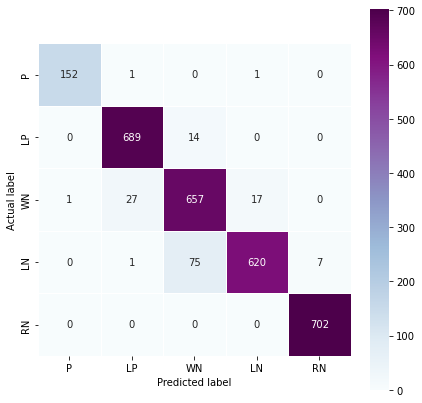

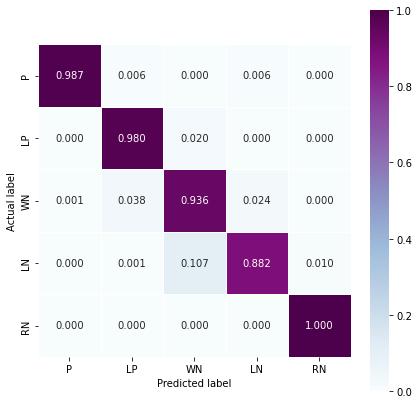

In [9]:
multiclass_data = create_dataset(G, 5).to(device)
sage_pred_multi, sage_prob_multi, sage_model = GDAClassification(multiclass_data, 'SAGE', 'Models/SAGE7L_multiclass_16HC_v2_max_40000_0_0005')

# Explainabilty

In [10]:
# Predicted P(ositive) genes in the test mask
# dictionaries with {gene: prob}
test_P      = {}
overall_LP  = {}

test_mask = multiclass_data.test_mask
test_preds = sage_pred_multi[test_mask]
test_probs = sage_prob_multi[test_mask]

test_nodes = []
i = 0
for node in G.nodes:
    if test_mask[i]:
        test_nodes.append(node)
    if sage_pred_multi[i] == 1 and node not in overall_LP:
        overall_LP[node] = sage_prob_multi[i][1].item() # take probability of class 1 (LP)
    i += 1

i = 0
for node in test_nodes:
    if test_preds[i] == 0 and node not in test_P: #P
        test_P[node] = test_probs[i][0].item() # take probability of class 0 (p)
    i += 1

print('# of predicted positive genes in test mask:', len(test_P))
print('# of predicted overall likely positive genes:', len(overall_LP))

# of predicted positive genes in test mask: 153
# of predicted overall likely positive genes: 4729


In [86]:
k_test_positive_genes   = 16
k_explanation_nodes     = 0.25
k_candidates_for_seed   = 10

top_k_test_P = heapq.nlargest(k_test_positive_genes, test_P, key=test_P.get)

# list of positive genes indexes in test_mask
top_k_test_P_idx = []

for node in top_k_test_P:
    i = 0
    for n in G.nodes:
        if node == n:
            top_k_test_P_idx.append(i)
            break
        i += 1

edge_index = multiclass_data.edge_index

# dict to store for each index the number of nodes (pos 0)
# and edges (pos 1) in the subgraph
subg_numnodes_d = {}

for i in top_k_test_P_idx:
    subg_nodes, subg_edge_index, subg_mapping, subg_edge_mask = torch_geometric.utils.k_hop_subgraph(i, 1, edge_index)
    if i not in subg_numnodes_d:
        subg_numnodes_d[i] = [len(subg_nodes), subg_edge_index.shape[1]]

### 1 Hop

In [ ]:
x = multiclass_data.x
y = multiclass_data.y
edge_index = multiclass_data.edge_index

candidates = {}

for i in tqdm(range(len(top_k_test_P_idx))):
    nodes_names = list(G.nodes)

    idx = top_k_test_P_idx[i]
    idx_name = nodes_names[idx]
    candidates[idx_name] = {}

    mean_mask = torch.zeros(edge_index.shape[1]).to('cpu')

    for i in tqdm(range(10)):
        explainer = GNNExplainer(sage_model, epochs=200, return_type='log_prob', num_hops=1, log=False)
        node_feat_mask, edge_mask = explainer.explain_node(idx, x, edge_index)
        mean_mask += edge_mask.to('cpu')

    mean_mask = torch.div(mean_mask, 10)

    num_nodes = int(round(subg_numnodes_d[idx][0]*k_explanation_nodes))

    values, indices = torch.topk(mean_mask, subg_numnodes_d[idx][1]) #take ordered list of all edges

    seen_genes = set()

    for i in range(len(indices)):
        src = edge_index[0][indices[i]]
        trgt = edge_index[1][indices[i]]

        src_name = nodes_names[src]
        trgt_name = nodes_names[trgt]

        src_pred = sage_pred_multi[src]
        trgt_pred = sage_pred_multi[trgt]

        # if gene has not been seen and it is not the explained node
        # we add it to the seen genes set
        if src_name != idx_name:
            seen_genes.add(src_name)
        if trgt_name != idx_name:
            seen_genes.add(trgt_name)

        if src_pred == 1: # LP
            if src_name not in candidates[idx_name]:
                candidates[idx_name][src_name] = values[i]
            else:
                candidates[idx_name][src_name] += values[i]

        if trgt_pred == 1: # LP

            if trgt_name not in candidates[idx_name]:
                candidates[idx_name][trgt_name] = values[i]
            else:
                candidates[idx_name][trgt_name] += values[i]
        
        # when the seen geens set reaches the num_nodes threshold
        # break the loop
        if len(seen_genes) >= num_nodes:
            break

all_top_LP = []
for seed in candidates:
    all_top_LP += heapq.nlargest(k_candidates_for_seed, candidates[seed], key=candidates[seed].get)

all_top_LP = list(set(all_top_LP))

In [83]:
len(all_top_LP)

100

In [84]:
extended_genes = pd.read_csv('Datasets/all_gene_disease_associations.tsv', sep='\t')
extended_genes = extended_genes[extended_genes['diseaseId'] == 'C0006142']
extended_genes_names = set(extended_genes['geneSymbol'].tolist())

genes_in_extended       = []
genes_not_in_extended   = []

for gene in all_top_LP:
    if gene in extended_genes_names:
        genes_in_extended.append(gene)
    else:
        genes_not_in_extended.append(gene)

print('# of genes found in the extended dataset:', len(genes_in_extended))

print('\n----')
for g in genes_in_extended:
    print(g, end=' ')
print('\n----')

for g in genes_not_in_extended:
    print(g, end=' ')
print()


# of genes found in the extended dataset: 67

----
SLC9A3R2 CDK9 MCM7 PLD1 XPO1 HSPA1A SLC9A3R1 ITPR1 CSNK2B GNL3 SP1 MAPK14 WDR5 HSPA5 ELAVL1 CBL BRD4 UBC ARRB1 RPS6KA1 LYN CSNK1E IKBKG PML NTRK1 ORC4 KIF14 HSPA8 TPT1 TRIM28 LAMP1 SLC5A6 RPA2 HSPB1 CFTR CSNK2A1 APP PIK3R1 HDAC3 PHB2 ARF6 SQSTM1 MYC ATAD3A KIF23 SMURF1 HDAC2 USP1 RACGAP1 TRIM25 STUB1 TERF2IP LMNA PLCG1 PSMD7 TGFBR1 RAB2A PNO1 RECQL4 BTRC MAP2K1 BAG3 NPM1 NRAS BCL2L1 APEX1 ABCE1 
----
IARS2 PPP1CC CDC37 CDC14B UQCRC1 FAM83H TCEB2 PKP4 TCEB3 FBXW11 GNB2L1 TEAD2 PSMC5 SPTA1 NDUFV3 PCF11 CCDC96 FARP2 PSMD6 TNIP2 DECR2 SPTBN1 PEX5 PLEKHA4 DPM1 ERC1 PSMD11 HIST1H4A KIAA1429 EFTUD2 RBBP4 ALMS1 PSMD12 


### 2 hops

In [ ]:
edge_index = multiclass_data.edge_index

# dict to store for each index the number of nodes (pos 0)
# and edges (pos 1) in the subgraph
subg_numnodes_d_2hop = {}

for i in top_k_test_P_idx:
    subg_nodes, subg_edge_index, subg_mapping, subg_edge_mask = torch_geometric.utils.k_hop_subgraph(i, 2, edge_index)
    if i not in subg_numnodes_d_2hop:
        subg_numnodes_d_2hop[i] = [len(subg_nodes), subg_edge_index.shape[1]]

subg_numnodes_d_2hop

In [87]:
x = multiclass_data.x
y = multiclass_data.y

edge_index  = multiclass_data.edge_index
nodes_names = list(G.nodes)

candidates_2hop = {}

for i in tqdm(range(len(top_k_test_P_idx))):
    
    idx = top_k_test_P_idx[i]
    idx_name = nodes_names[idx]

    # START of explainability
    # Compute the mean mask as the mean of the masks returned by
    # 10 explanations

    mean_mask = torch.zeros(edge_index.shape[1]).to('cpu')

    for i in tqdm(range(10)):
        explainer = GNNExplainer(sage_model, epochs=200, return_type='log_prob', num_hops=2, log=False)
        node_feat_mask, edge_mask = explainer.explain_node(idx, x, edge_index)
        mean_mask += edge_mask.to('cpu')

    mean_mask = torch.div(mean_mask, 10)

    # END of explanaibility

    # number of LP nodes to take from the seed gene
    num_nodes = int(round(subg_numnodes_d_2hop[idx][0]*k_explanation_nodes))

    values, indices = torch.topk(mean_mask, subg_numnodes_d_2hop[idx][1]) #take ordered list of all edges

    seen_genes = set()

    for i in range(len(indices)):
        src = edge_index[0][indices[i]]
        trgt = edge_index[1][indices[i]]

        src_name = nodes_names[src]
        trgt_name = nodes_names[trgt]

        src_pred = sage_pred_multi[src]
        trgt_pred = sage_pred_multi[trgt]

        src_trgt_genes = {src_name: src_pred, trgt_name: trgt_pred}

        for g in src_trgt_genes:
            # if pred == LP and the gene has not been seen multiple times for the same seed gene
            if src_trgt_genes[g] == 1 and g not in seen_genes:
                seen_genes.add(g)
                if g not in candidates_2hop:
                    candidates_2hop[g] = {'counter': 1, 'score': values[i]}
                else:
                    candidates_2hop[g]['counter'] += 1
                    candidates_2hop[g]['score'] += values[i]
        
        # when the seen geens set reaches the num_nodes threshold
        # break the loop
        if len(seen_genes) >= num_nodes:
            break

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [88]:
all_top_LP_2hop = sorted(candidates_2hop.items(), key=lambda x: (x[1]['counter'], x[1]['score'].item()), reverse=True)
len(all_top_LP_2hop)

911

In [89]:
all_top_k_2hop = [item[0] for item in all_top_LP_2hop][:100]

In [90]:
extended_genes = pd.read_csv('Datasets/all_gene_disease_associations.tsv', sep='\t')
extended_genes = extended_genes[extended_genes['diseaseId'] == 'C0006142']
extended_genes_names = set(extended_genes['geneSymbol'].tolist())

genes_in_extended       = []
genes_not_in_extended   = []

for gene in all_top_k_2hop:
    if gene in extended_genes_names:
        genes_in_extended.append(gene)
    else:
        genes_not_in_extended.append(gene)

print('# of genes found in the extended dataset:', len(genes_in_extended))

print('\n----')
for g in genes_in_extended:
    print(g, end=' ')
print('\n----')

for g in genes_not_in_extended:
    print(g, end=' ')
print()

# of genes found in the extended dataset: 68

----
HSPA8 MYC FZR1 AURKB KIF14 NTRK1 NPM1 HSP90AB1 CFTR ELAVL1 SQSTM1 KIF23 LMNA CIT CYLD TMPO LRRK2 PSMC3 CUL3 ARNT ATAD3A APEX1 APP HSPB1 HEXIM1 JUP PPP1R9B EMD CTBP1 TRAF6 UBE2I EGLN3 HSPA5 RBM39 YWHAE PLCG1 PPP2R1A TRIM28 NR2C2 NRAS PSMD4 UBC ILK GAPDH CCND2 ACTB STUB1 CCNF BRD4 CDK2 PPP1R13B LMNB1 LYN CRK PRKDC RPL13 MAP1LC3B MYH10 CUL4A MAPK1 TTN ARF6 USP9X BLM TRIM25 XRCC5 FAM83B PRKCZ 
----
KIAA1429 PLEKHA4 EFTUD2 CDC37 YWHAQ HIST1H4A TNIP2 TCEB3 OBSL1 METTL14 WWP2 CAND1 RPS5 AP2M1 LMO7 ARHGAP21 PCBP2 FAM83H ATP5A1 TTLL5 SPTBN1 RPS24 RPS11 PLEC NUP107 NOP56 KIAA1671 NUP93 YWHAH ESYT2 PPP1CC ERH 
